In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots
using LinearAlgebra
using Random

import ProgressMeter

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [11]:
import ReactiveMP: @rule, @marginalrule, score

@rule(
    form => Type{ <: MvNormalMeanPrecision },
    on   => :μ,
    vconstraint => Marginalisation,
    messages => (m_out::ReactiveMP.FnWithApproximation, ),
    marginals => (q_Λ::Dirac, ),
    meta => Nothing,
    begin
        vindex = ReactiveMP.varindex(__node, :μ)
        vin    = @inbounds ReactiveMP.variables(__node)[vindex]
        return vin.m_in |> take(1) |> map(MvNormalMeanPrecision, (m_μ) -> begin
            inv_q_Λ        = cholinv(mean(q_Λ))
            msg_fwd        = MvNormalMeanPrecision(mean(m_μ), cholinv(cov(m_μ) + inv_q_Λ))
            multiplication = getdata(as_message(msg_fwd) * as_message(m_out))
            
            m, c = mean(multiplication), cov(multiplication)
            return MvNormalMeanPrecision(m, cholinv(c + inv_q_Λ))
        end)
    end
)

fallback_approx(x) = x
fallback_approx(x::ReactiveMP.LaplaceApproximation) = srcubature()

@marginalrule(
    form => Type{ <: MvNormalMeanPrecision },
    on   => :out_μ,
    messages => (m_out::ReactiveMP.FnWithApproximation, m_μ::MvNormalMeanPrecision),
    marginals => (q_Λ::Dirac, ),
    meta => Nothing,
    begin
        d = ndims(m_μ)
        
        m_mean_mean, m_mean_cov = mean(m_μ), cov(m_μ)
        
        Wbar = mean(q_Λ)
        
        W = [ Wbar -Wbar; -Wbar Wbar ]

        logpdf = m_out.fn

        msg_fwd    = MvNormalMeanPrecision(mean(m_μ), cholinv(cov(m_μ) + cholinv(mean(q_Λ))))
        v_mean_inv = precision(m_μ)

        l(z) = @views -0.5 * z'*W*z - 0.5 * (z[d+1:end] - m_mean_mean)' * v_mean_inv * (z[d+1:end] - m_mean_mean) + logpdf(z[1:d])

        #Expansion point
        point1 = mean(as_message(msg_fwd) * as_message(m_out))

        try
            m_joint, v_joint = ForneyLab.NewtonMethod(l, [ point1; m_mean_mean ])
            return MvNormalMeanPrecision(m_joint, cholinv(v_joint))
        catch e
            # Use cubature as a fallback
            cubature = fallback_approx(m_out.approximation)
            mean, cov = ReactiveMP.approximate_meancov(cubature, (x) -> exp(logpdf(x)), msg_fwd)
            
            approx_prec = [ inv(cov) + Wbar -Wbar; -Wbar inv(m_mean_cov) + Wbar ]
            approx_mean = cholinv(approx_prec) * [ cholinv(cov) * mean; cholinv(m_mean_cov) * m_mean_mean ]
            
            return MvNormalMeanPrecision(approx_mean, approx_prec)
        end
    end
)

function ReactiveMP.score(::AverageEnergy, ::Type{ <: MvNormalMeanPrecision }, marginals::Tuple{ <: Marginal,  <: Marginal, <: Marginal }, ::Nothing)
    marg_out  = marginals[1]
    marg_mean = marginals[2]
    marg_prec = marginals[3]
    
    (m_mean, v_mean) = mean(marg_mean), cov(marg_mean)
    (m_out, v_out)   = mean(marg_out), cov(marg_out)

    0.5*ndims(marg_out)*log(2*pi) +
    0.5*logdet(cholinv(mean(marg_prec))) +
    0.5*tr(mean(marg_prec)*(v_out + v_mean + (m_out - m_mean)*(m_out - m_mean)'))
end

function ReactiveMP.score(::AverageEnergy, ::Type{ <: MvNormalMeanPrecision }, marginals::Tuple{ <: Marginal, <: Marginal }, ::Nothing)
    marg_out_mean = marginals[1]
    marg_prec     = marginals[2]
    
    (m, V) = mean(marg_out_mean), cov(marg_out_mean)
    d = Int64(ndims(marg_out_mean)/2)

    0.5*d*log(2*pi) +
    0.5*logdet(cholinv(mean(marg_prec))) +
    0.5*tr(mean(marg_prec)*( V[1:d,1:d] - V[1:d,d+1:end] - V[d+1:end,1:d] + V[d+1:end,d+1:end] + (m[1:d] - m[d+1:end])*(m[1:d] - m[d+1:end])' ) )
end

function ReactiveMP.score(::AverageEnergy, ::Type{ <: KernelGCV }, marginals::Tuple{ <: Marginal{ <: MvNormalMeanPrecision }, <: Marginal{ <: MvNormalMeanPrecision } }, meta::KernelGCVMetadata)
    marg_out_mean = marginals[1]
    marg_z        = marginals[2]
    
    (m, V) = mean(marg_out_mean), cov(marg_out_mean)
    (mz,Vz) = mean(marg_z), cov(marg_z)

    d = Int64(ndims(marg_out_mean) / 2)

    cubature = fallback_approx(ReactiveMP.get_approximation(meta))
    weights = ReactiveMP.getweights(cubature, mz, Vz)
    points  = ReactiveMP.getpoints(cubature, mz, Vz)
    
    kernelfn = ReactiveMP.get_kernelfn(meta)

    gs = Base.Generator(points) do point
        return kernelfn(point)
    end

    Λ_out = mapreduce(t -> t[1] * cholinv(t[2]), +, zip(weights, gs))
    log_det_sum = mapreduce(t -> t[1] * log(det(t[2])), +, zip(weights, gs))

    @views 0.5*d*log(2*pi) +
    0.5*log_det_sum +
    0.5*tr( Λ_out*( V[1:d,1:d] - V[1:d,d+1:end] - V[d+1:end,1:d] + V[d+1:end,d+1:end] + (m[1:d] - m[d+1:end])*(m[1:d] - m[d+1:end])' ) )
end

In [3]:
function hgf(; n, iters, ndim, data, z_precision, y_precision, kfunction, approximation, prior_xt, prior_zt)
    model = Model()
    
    xt_min_mean = datavar(model, :xt_min_mean, Dirac{Vector{Float64}})
    xt_min_prec = datavar(model, :xt_min_prec, Dirac{Matrix{Float64}})
    xt_min      = randomvar(model, :xt_min)
    
    xt_min_prior = make_node(model, MvNormalMeanPrecision, xt_min, xt_min_mean, xt_min_prec)
    
    zt_min_mean = datavar(model, :zt_min_mean, Dirac{Vector{Float64}})
    zt_min_prec = datavar(model, :zt_min_prec, Dirac{Matrix{Float64}})
    zt_min      = randomvar(model, :zt_min)
    
    zt_min_prior = make_node(model, MvNormalMeanPrecision, zt_min, zt_min_mean, zt_min_prec)
    
    zprec  = constvar(model, :zcov, z_precision)
    zt     = randomvar(model, :zt)

    z_transition =make_node(model, MvNormalMeanPrecision, zt, zt_min, zprec, factorisation = ((1,2),(3,)))
    
    xt = randomvar(model, :xt)
    
    gcv = make_node(model, KernelGCV, KernelGCVMetadata(kfunction, approximation), xt, xt_min, zt)
    
    yprec = constvar(model, :ycov, y_precision)
    y     = datavar(model, :y, Dirac{Vector{Float64}})
    
    obs = make_node(model, MvNormalMeanPrecision, y, xt, yprec)
    
    activate!(model)
    
    ms_scheduler = PendingScheduler()
    fe_scheduler = PendingScheduler() # 
    fe = Vector{Float64}()    
    
    fe_sub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d))
    
    mz = Vector{MvNormalMeanPrecision}()
    mx = Vector{MvNormalMeanPrecision}()

    s_mz = subscribe!(getmarginal(zt) |> schedule_on(ms_scheduler), (t) -> push!(mz, getdata(t)))
    s_mx = subscribe!(getmarginal(xt) |> schedule_on(ms_scheduler), (t) -> push!(mx, getdata(t)))
    
    # Initial prior messages
    current_zt = prior_zt
    current_xt = prior_xt

    # Prior marginals
    setmarginal!(gcv, :y_x, MvNormalMeanPrecision(zeros(2ndim), ones(2ndim)))
    setmarginal!(gcv, :z, MvNormalMeanPrecision(zeros(ndim), ones(ndim)))
    
    ProgressMeter.@showprogress for i in 1:n
        
        for _ in 1:iters
            update!(y, data[i])
            update!(xt_min_mean, mean(current_xt))
            update!(xt_min_prec, precision(current_xt))
            update!(zt_min_mean, mean(current_zt))
            update!(zt_min_prec, precision(current_zt))
            
            release!(fe_scheduler)
        end
        
        release!(ms_scheduler)
        
        current_zt = mz[end]
        current_xt = mx[end]
    end
    
    unsubscribe!(s_mz)
    unsubscribe!(s_mx)
    unsubscribe!(fe_sub)
    
    return mz, mx, fe
end

hgf (generic function with 1 method)

In [4]:
using KernelFunctions

In [5]:
ndim  = 4

kfunction = (d) -> 0.05 * (kernelmatrix(LinearKernel(c = 1.0), d) + Diagonal(1.0 * ones(4)) + Diagonal(exp.(d)))

#23 (generic function with 1 method)

In [6]:
n     = 500
iters = 7

Random.seed!(2212)

approximation = srcubature()

z_prev = zeros(ndim)
x_prev = zeros(ndim)

z_covariance = Matrix(Diagonal(0.010 * ones(ndim)))
y_variance   = 0.001 * ones(ndim)
y_covariance = Matrix(Diagonal(y_variance))

z = Vector{Vector{Float64}}(undef, n)
v = Vector{Matrix{Float64}}(undef, n)
x = Vector{Vector{Float64}}(undef, n)
y = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    z[i] = rand(MvNormal(z_prev, z_covariance))
    v[i] = kfunction(z[i])
    x[i] = rand(MvNormal(x_prev, v[i]))
    y[i] = rand(MvNormal(x[i], y_covariance))
    z_prev = z[i]
    x_prev = x[i]
end

identityM = Matrix(Diagonal(ones(ndim)))

prior_zt = MvNormalMeanPrecision(zeros(ndim), identityM)
prior_xt = MvNormalMeanPrecision(zeros(ndim), identityM);

In [13]:
@time mz, mx, fe = hgf(
    n             = n, 
    iters         = iters, 
    ndim          = ndim,
    data          = y, 
    z_precision   = cholinv(z_covariance), 
    y_precision   = cholinv(y_covariance), 
    kfunction     = kfunction,
    approximation = approximation,
    prior_zt      = prior_zt,
    prior_xt      = prior_xt
);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  2.895473 seconds (11.56 M allocations: 1.431 GiB, 7.20% gc time)


In [14]:
function plot_dimension(mz, mx, ys, dim = 1)
    p1 = plot(map(d -> d[dim], mean.(mz)), ribbon = map(d -> sqrt(d[dim]), var.(mz)), label = :z)
    p1 = plot!(p1, map(d -> d[dim], z), label = :real_z)

    p2 = plot(map(d -> d[dim], mean.(mx)), ribbon = map(d -> sqrt(d[dim]), var.(mx)), label = :x)
    p2 = plot!(p2, map(d -> d[dim], x), label = :real_x)
    p2 = scatter!(map(d -> d[dim], ys), ms = 2)

    
    inds = 300:325
    ex = map(d -> d[dim], mean.(mx))
    ex_min, ex_max = minimum(ex[inds]), maximum(ex[inds])
    
    p2 = lens!(p2, [ inds[1], inds[end] ], [ ex_min, ex_max ], inset = (1, bbox(0.5, 0.0, 0.4, 0.4)))
    

    plot(p1, p2, layout = (1, 2), size = (1400, 200), legend = false)
end

plot_dimension (generic function with 2 methods)

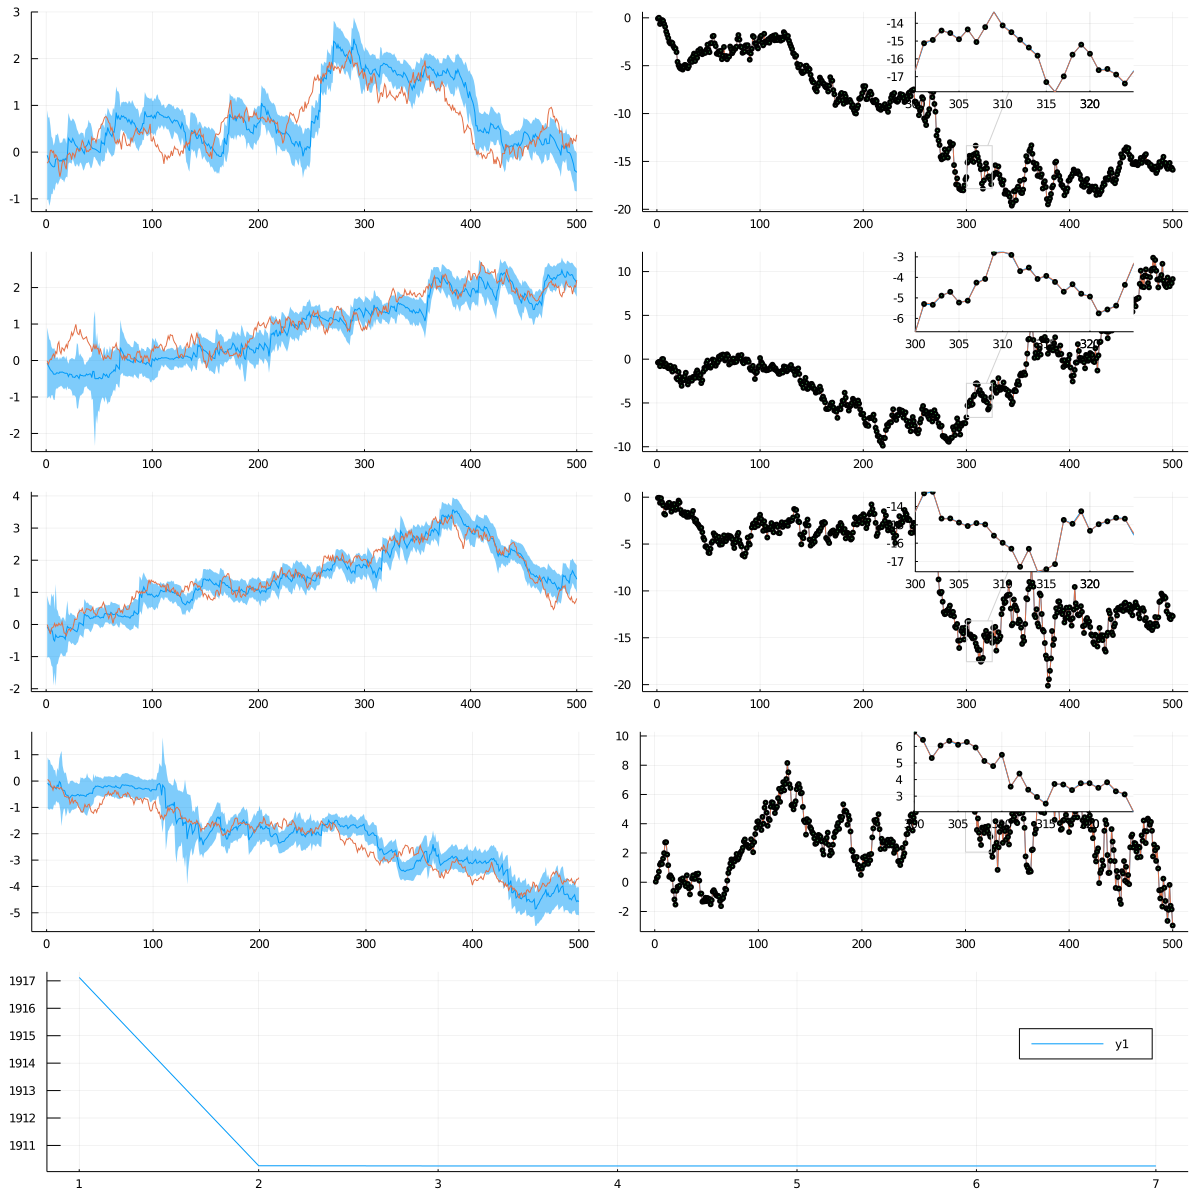

In [15]:
fevalues = vec(sum(reshape(fe, (iters, n)), dims = 2))

plot(map(i -> plot_dimension(mz, mx, y, i), 1:ndim)..., plot(fevalues), layout = (ndim + 1, 1), size = (1200, 1200))